## Imports

In [602]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

## Setup dataframes etc

In [603]:
leg = ['Alcohol', 'Caff', 'Choc', 'Legalh',  'Nicotine']
ileg = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',  'LSD', 'Meth', 'Mushrooms', 'VSA']
fic = ['Semer']

pers = ['neuroticism', 'extraversion', 'openness', 'agreeableness', 'conscientiousness', 'impulsive', 'sensation', 'intercept']
features = ['age', 'gender', 'education', 'country', 'ethnicity'] + pers


df = pd.read_csv('data/raw/data.csv', sep=',', index_col='id')

df2 = df.copy()

use_mapping = {'CL0': 0, #never used
               'CL1': 1, #over a decade ago
               'CL2': 1, #within the last decade
               'CL3': 1, #within the last year
               'CL4': 1, #within the last month
               'CL5': 1, #within the last week
               'CL6': 1} #within the last day

for j in ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']:
    temp = []
    for i in df[j]:
        temp.append(use_mapping[i])

    df2[j] = temp

ed_mapping = {'Left school before 16 years': 1,
                'Left school at 16 years':2,
                'Left school at 17 years':3,
                'Left school at 18 years':4,
                'Some college or university, no certificate or degree':5,
                'Professional certificate/ diploma':6,
                'University degree':7,
                'Masters degree':8,
                'Doctorate degree':9,}

age_mapping = {'18-24':0,
               '25-34':1,
               '35-44':2,
               '45-54':3,
               '55-64':4,
               '65+':5}

gender_mapping = {'Female':0, 'Male':1}

country_mapping = {'UK':0, 
                   'Canada':2, 
                   'USA':1, 
                   'Other':2, 
                   'Australia':2, 
                   'Republic of Ireland':2,
                   'New Zealand':2}

ethnicity_mapping = {'Mixed-White/Asian':1,
                     'White':0,
                     'Other':1,
                     'Mixed-White/Black':1,
                     'Asian':1, 
                     'Black':2, 
                     'Mixed-Black/Asian':1}

df2.age = df2.age.map(age_mapping)
df2.gender = df2.gender.map(gender_mapping)
df2.education = df2.education.map(ed_mapping)
df2.country = df2.country.map(country_mapping)
df2.ethnicity = df2.ethnicity.map(ethnicity_mapping)

df2['any_illeg'] = 0
df2.loc[df2[ileg].sum(axis=1) > 0,'any_illeg'] = 1
df2['intercept'] = 1 #add intercept column for statsmodel


In [604]:

df2.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,...,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,any_illeg,intercept
id,,,,,,,,,,,,,,,,,,,,,
1,2,0,6,0,1,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,1,0,0,1,1
2,1,1,9,0,0,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,1,1,0,1,0,0,1,1
3,2,1,6,0,0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,1,0,0,0,1,1
4,0,0,8,0,0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,1,0,0,0,0,1,0,0,1,1
5,2,0,9,0,0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,1,0,0,1,1,0,0,1,1


## Helper functions

In [605]:
def logistic(X):
    '''Given X, returns 1/(1+e^X)'''
    return 1/(1 + np.exp(X))

def predictor(clf, X, threshold):
    '''Given a model that predicts probabilities, returns 0-1 predictions with 0.5 threshold'''
    y_pred = clf.predict(X)
    return [0 if a < threshold else 1 for a in y_pred]

In [606]:
drug = 'any_illeg'
X = df2[pers]
y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [607]:
X_train

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsive,sensation,intercept
id,,,,,,,,
1707,-0.92104,0.32197,-1.42424,-0.60633,1.81175,-0.21712,0.07987,1
1754,-0.14882,1.58487,-0.01928,0.13136,-0.40581,0.88113,0.07987,1
23,0.41667,-0.94779,-0.84732,1.11406,-0.89891,-0.71126,0.07987,1
1621,1.37297,-0.30033,-0.97631,-0.30172,-0.27607,0.19268,-0.52593,1
838,-1.69163,0.16767,-0.01928,-0.30172,-1.51840,0.19268,0.07987,1
...,...,...,...,...,...,...,...,...
1412,0.41667,-0.30033,1.43533,-0.30172,1.46191,-0.21712,0.40148,1
669,-1.69163,2.12700,0.14143,0.28783,-0.40581,0.19268,-0.21575,1
1519,0.04257,-1.63340,1.88511,-0.91699,0.12331,0.19268,0.40148,1


In [608]:
clf = sm.Logit(y_train, X_train).fit()

clf.summary()

Optimization terminated successfully.
         Current function value: 0.346218
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              any_illeg   No. Observations:                 1508
Model:                          Logit   Df Residuals:                     1500
Method:                           MLE   Df Model:                            7
Date:                Sat, 30 Dec 2023   Pseudo R-squ.:                  0.2100
Time:                        12:55:25   Log-Likelihood:                -522.10
converged:                       True   LL-Null:                       -660.90
Covariance Type:            nonrobust   LLR p-value:                 3.651e-56
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
neuroticism           0.0159      0.097      0.164      0.870      -0.174       0.206
extraversion         -0.3499      0.103     -3.385      0.001      -0.552      -0.147
openness              0.6060      0.093      6.499      0.000       0.423       0.789
agreeableness        -0.2480      0.088     -2.831      0.005      -0.420      -0.076
conscientiousness    -0.4734      0.098     -4.841      0.000      -0.665      -0.282
impulsive             0.0717      0.115      0.621      0.534      -0.154       0.298
sensation             0.7051      0.121      5.810      0.000       0.467       0.943
intercept             2.2067      0.104     21.316      0.000       2.004       2.410
=====================================================================================
"""

### Interpretation:

p-vals are interesting here, neuroticism and impulsiveness not significant, suggesting these traits are not useful in predicting drug use.

In [609]:
beta = np.array(clf.params).reshape(-1,1)
samp = np.array(X_train.iloc[244]).reshape(1,-1) #get a single samp for testing

logistic(samp@beta)[0][0], 1-clf.predict(samp)[0] #chance of belonging to the '0' class. This is just for my sanity check.

(0.02784014370699088, 0.02784014370699084)

Explaining Odds Ratios: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/ 

Odds ratios are used to compare the relative odds of the occurrence of the outcome of interest (e.g. disease or disorder), given exposure to the variable of interest (e.g. health characteristic, aspect of medical history). The odds ratio can also be used to determine whether a particular exposure is a risk factor for a particular outcome, and to compare the magnitude of various risk factors for that outcome.

OR=1 Exposure does not affect odds of outcome

OR>1 Exposure associated with higher odds of outcome

OR<1 Exposure associated with lower odds of outcome

In [610]:
# code from https://www.andrewvillazon.com/logistic-regression-python-statsmodels/

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

print(odds_ratios) 

                         OR  Lower CI   Upper CI
neuroticism        1.016051  0.839890   1.229162
extraversion       0.704760  0.575515   0.863030
openness           1.833156  1.526943   2.200776
agreeableness      0.780328  0.657216   0.926501
conscientiousness  0.622864  0.514228   0.754451
impulsive          1.074281  0.856945   1.346738
sensation          2.023958  1.595565   2.567370
intercept          9.085266  7.416843  11.129002


In [611]:
y_pred = predictor(clf, X_test, 0.5)

f1_score(y_pred, y_test)

0.9044776119402985

In [612]:
drug_df = pd.DataFrame(index=pers[:-1])

Optimization terminated successfully.
         Current function value: 0.370345
         Iterations 6
Drug: Crack
F1 score: 0.0
                          OR  Lower CI  Upper CI     coefs  p_values
neuroticism        1.088026  0.909726  1.301272  0.084365     0.356
extraversion       0.756468  0.634709  0.901585 -0.279095     0.002
openness           1.239266  1.046457  1.467600  0.214519     0.013
agreeableness      0.949065  0.811131  1.110454 -0.052278     0.514
conscientiousness  0.977359  0.819287  1.165928 -0.022901     0.799
impulsive          1.229830  0.993982  1.521639  0.206876     0.057
sensation          1.539199  1.241286  1.908613  0.431262     0.000
intercept          0.131295  0.110724  0.155688 -2.030310     0.000


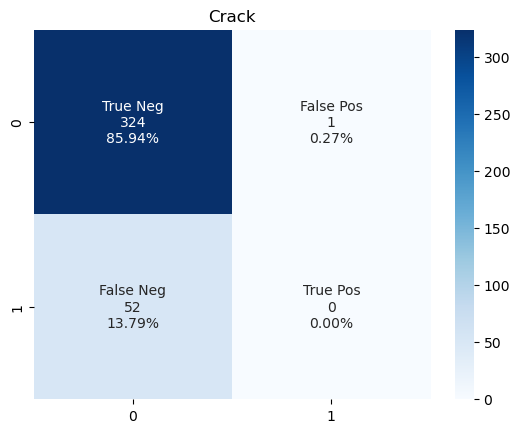

In [613]:
drug = 'Crack'

y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, 0.5)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

In [614]:
def stats(drug, drug_df):
    y = df2[drug]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = sm.Logit(y_train, X_train).fit()

    odds_ratios = pd.DataFrame(
        {
            "OR": clf.params,
            "Lower CI": clf.conf_int()[0],
            "Upper CI": clf.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)

    odds_ratios['coefs'] = clf.params
    odds_ratios['p_values'] = clf.pvalues.round(3)

    y_pred = predictor(clf, X_test, 0.5)
    drug_df[drug] = abs(1-odds_ratios['OR']).T
    drug_df.loc['F1', drug] = f1_score(y_pred, y_test)
    print(f1_score(y_pred, y_test))

    return drug_df

In [615]:
drug_df = pd.read_csv('data/other/drug_use_decade.csv', index_col=0)

drug_df.loc['F1']

Amphet       0.462882
Amyl         0.000000
Benzos       0.526718
Cannabis     0.846580
Coke         0.466960
Crack        0.000000
Ecstasy      0.632997
Heroin       0.000000
Ketamine     0.076923
LSD          0.497297
Meth         0.224299
Mushrooms    0.588235
VSA          0.000000
Alcohol      0.981081
Caff         0.990629
Choc         0.990629
Legalh       0.671186
Nicotine     0.796429
Name: F1, dtype: float64

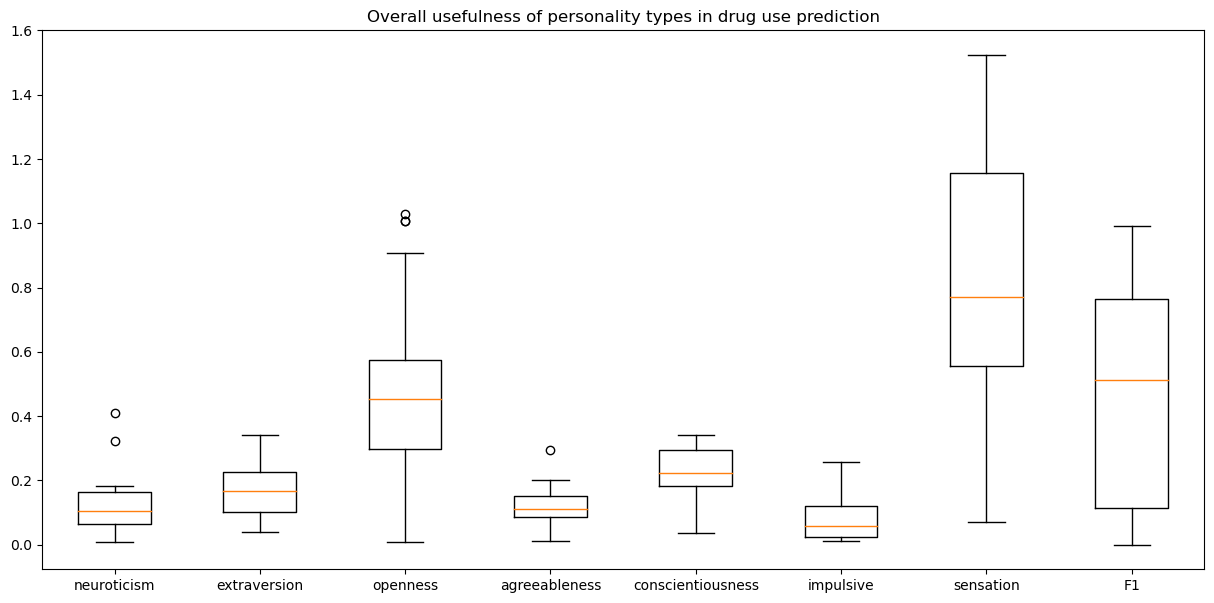

In [616]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df.T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in drug use prediction');

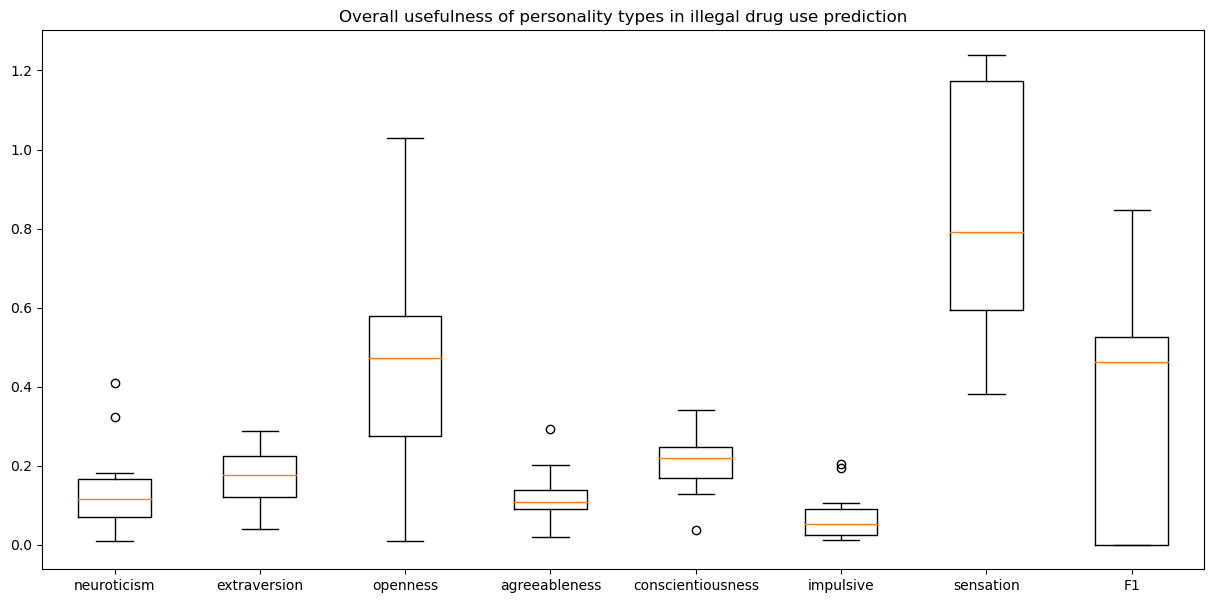

In [617]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[ileg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in illegal drug use prediction');

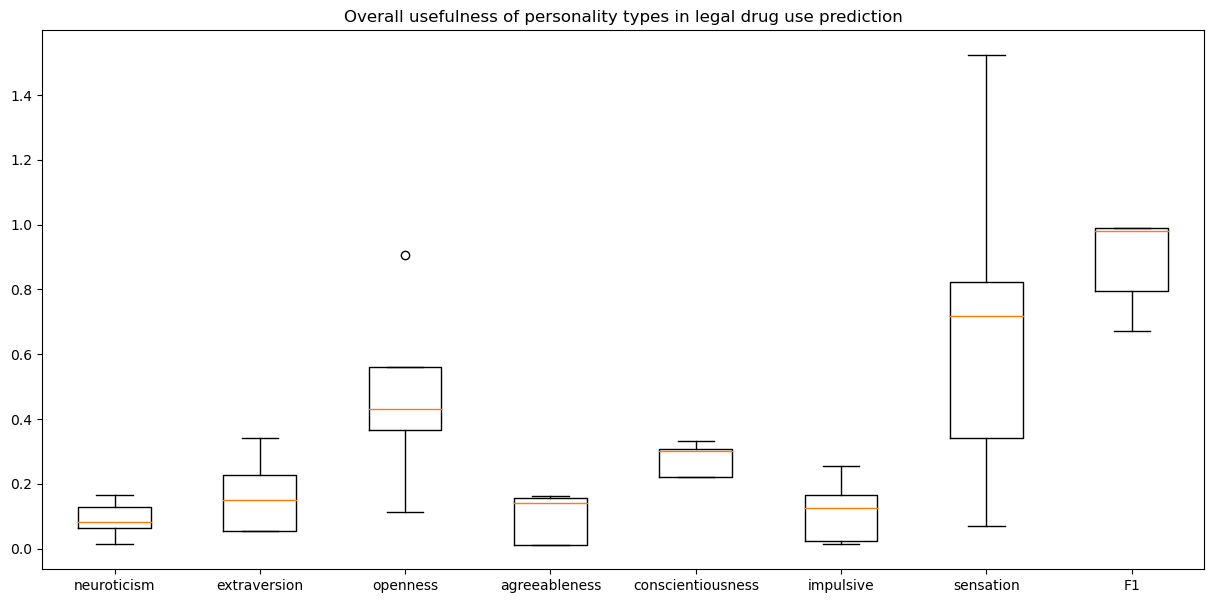

In [618]:
_, ax = plt.subplots(1,1, figsize=(15,7))

ax.boxplot(drug_df[leg].T, labels=pers[:-1]+['F1'])
ax.set_title('Overall usefulness of personality types in legal drug use prediction');

### What we've learnt:

Personality traits are useful in predicting drug use in some time scales and in some drugs

?? Do some drugs have more in common, ie similar traits useful, and if so, are they useful in the same direction?

Optimization terminated successfully.
         Current function value: 0.412390
         Iterations 7
Drug: Cannabis
F1 score: 0.881
                          OR  Lower CI  Upper CI     coefs  p_values
neuroticism        0.958463  0.806835  1.138587 -0.042424     0.629
extraversion       0.651398  0.542109  0.782720 -0.428635     0.000
openness           2.148697  1.813094  2.546420  0.764862     0.000
agreeableness      0.877969  0.751288  1.026011 -0.130144     0.102
conscientiousness  0.672015  0.566812  0.796743 -0.397475     0.000
impulsive          0.996202  0.819513  1.210986 -0.003805     0.970
sensation          2.127646  1.722973  2.627365  0.755016     0.000
intercept          5.611184  4.734674  6.649960  1.724762     0.000


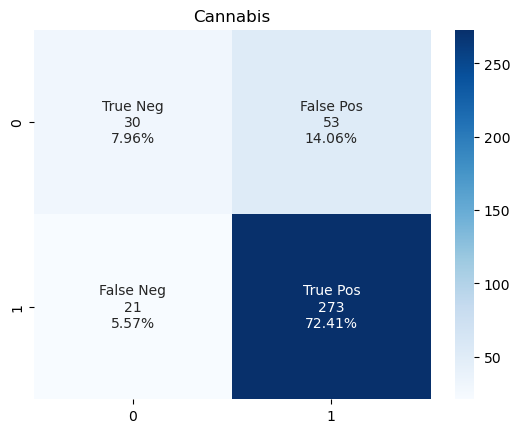

In [705]:
X = df2[pers]

drug = 'Cannabis'

y = df2[drug]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



clf = sm.Logit(y_train, X_train).fit()

#print(clf.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": clf.params,
        "Lower CI": clf.conf_int()[0],
        "Upper CI": clf.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios['coefs'] = clf.params
odds_ratios['p_values'] = clf.pvalues.round(3)



y_pred = predictor(clf, X_test, 0.5)
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}\n {odds_ratios}')

_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

Using additional demographic data improves the overall F1 score.

In [706]:
drug_df2 = pd.DataFrame()

for d in ileg+leg:
    drug_df2 = stats(d, drug_df2)

Optimization terminated successfully.
         Current function value: 0.622173
         Iterations 5
0.6686217008797655
Optimization terminated successfully.
         Current function value: 0.593991
         Iterations 5
0.0746268656716418
Optimization terminated successfully.
         Current function value: 0.628130
         Iterations 5
0.6491228070175439
Optimization terminated successfully.
         Current function value: 0.412390
         Iterations 7
0.8806451612903227
Optimization terminated successfully.
         Current function value: 0.615793
         Iterations 5
0.5679758308157099
Optimization terminated successfully.
         Current function value: 0.370345
         Iterations 6
0.0
Optimization terminated successfully.
         Current function value: 0.586382
         Iterations 5
0.632183908045977
Optimization terminated successfully.
         Current function value: 0.372886
         Iterations 7
0.1875
Optimization terminated successfully.
         Current funct

In [707]:
drug_df2.loc['F1']

Amphet       0.668622
Amyl         0.074627
Benzos       0.649123
Cannabis     0.880645
Coke         0.567976
Crack        0.000000
Ecstasy      0.632184
Heroin       0.187500
Ketamine     0.065934
LSD          0.637500
Meth         0.322581
Mushrooms    0.723861
VSA          0.103093
Alcohol      0.990629
Caff         0.993324
Choc         0.991979
Legalh       0.617940
Nicotine     0.875758
Name: F1, dtype: float64

In [708]:
probs = clf.predict(X_test)

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs)

f1s = 2*(precision*recall)/(precision+recall)

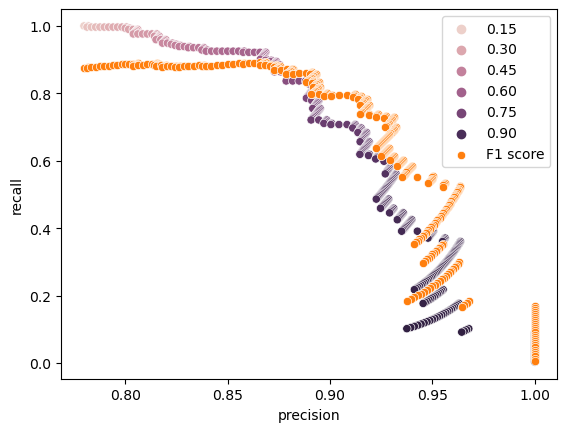

In [709]:
sns.scatterplot(x=precision[:-1], y=recall[:-1], hue=thresholds)
sns.scatterplot(y=f1s[:-1],x=precision[:-1], label='F1 score')
plt.xlabel('precision')
plt.ylabel('recall');

In [710]:
f1s = f1s[~np.isnan(f1s)] #remove invalid F1 scores where precision/recall = 0

print(f'max F1:{f1s[f1s.argmax()]}\nprecision: {precision[f1s.argmax()]}\nrecall: {recall[f1s.argmax()]}\nthreshold: {thresholds[f1s.argmax()]}')


max F1:0.8943894389438944
precision: 0.8685897435897436
recall: 0.9217687074829932
threshold: 0.6008028730856896


Drug: Cannabis
F1 score: 0.894


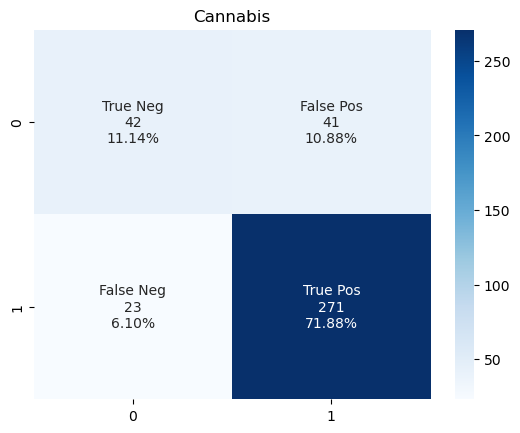

In [711]:
y_pred = predictor(clf, X_test, thresholds[f1s.argmax()])
cm = confusion_matrix(y_test, y_pred)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}')
F1 = f1_score(y_pred, y_test)
_, axes = plt.subplots(1,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
axes.set_title(f'{drug}')
axes.set_xlabel('predicted')
axes.set_ylabel('true')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes);

## Create a null model to test against


In [712]:
def rand_classifier(X, y_train):
    '''randomly assigns to a class depending on the training class probabilities'''
    #np.random.seed(42)
    p = y_train.sum()/ y_train.shape[0] # percentage positive in training set.

    y_pred = []

    for _ in X.values:
        if np.random.random() > p:
            y_pred.append(0)
        else:
            y_pred.append(1)

    return np.array(y_pred)


In [713]:
y_pred = rand_classifier(X_test, y_train)

print(f'Drug: {drug}\nF1 score: {f1_score(y_pred, y_test):.3}') # a single test isn't sufficient, but we can make multiple tests to create a confidence interval.

Drug: Cannabis
F1 score: 0.782


In [714]:
from scipy.stats import norm


In [715]:
n = 10000
av_f1 = []
for _ in range(n):
    y_pred = rand_classifier(X_test, y_train)
    av_f1.append(f1_score(y_pred, y_test))

    
mu, std = norm.fit(av_f1)   

print(f'Mean:{sum(av_f1)/n}\nConfidence interval: {np.percentile(av_f1, 2.5)}, {np.percentile(av_f1, 97.5)}\nprob of getting F1 of {F1:.3}: {norm.sf(F1,mu,std):.3}')

Mean:0.7803234868804606
Confidence interval: 0.7482758620689656, 0.8100021008403361
prob of getting F1 of 0.894: 1.72e-13


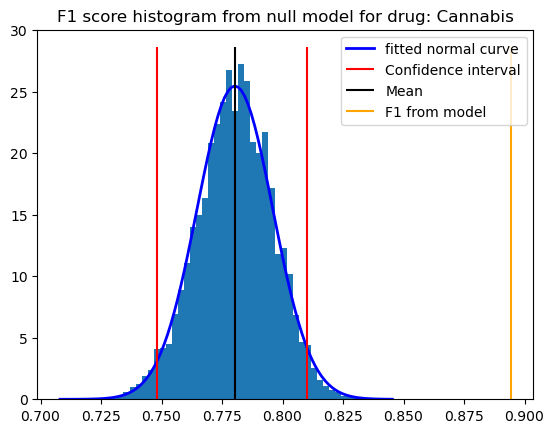

In [716]:
plt.hist(av_f1, bins=50, density=True)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'blue', linewidth=2, label='fitted normal curve')

plt.vlines(x=[np.percentile(av_f1, 2.5),np.percentile(av_f1, 97.5)], ymin=ymin, ymax=ymax, color='r', label='Confidence interval')
plt.vlines(x=[sum(av_f1)/n], ymin=ymin, ymax=ymax, color='k', label='Mean')
plt.vlines(x=F1, ymin=ymin, ymax=ymax, color='orange', label='F1 from model')
plt.title(f'F1 score histogram from null model for drug: {drug}')
plt.legend();

So for 

'Crack', our F1 score of 0.371 is outside of the confidence interval from the null model, with a very small p-val so we can consider it statistically significant: Personality data can be used to predict drug usage.

'Cannabis', our F1 score of 0.894 is outside of the confidence interval from the null model, with a very small p-val so we can consider it statistically significant: Personality data can be used to predict drug usage.

## Next steps: 

Put this together nicely to calc for each drug. Then calc a correction for multihypothosis testing.